In [5]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})


def tsallis_probabilities(u, q=2, eta=1, gamma=1.0, tol=1e-12, max_iter=200):
    # Compute Tsallis-regularized choice probabilities without cvxpy.
    u = np.asarray(u, dtype=float)
    N = u.size
    if gamma <= 0 or q <= 1:
        raise ValueError("Require gamma>0 and q>1")

    # eta is kept for API compatibility (unused in the original cvxpy objective)
    c = (q - 1.0) / (gamma * q)
    power = 1.0 / (q - 1.0)

    def S(tau):
        return float(np.sum(np.maximum(0.0, c * (u - tau)) ** power))

    u_max = float(np.max(u))
    u_min = float(np.min(u))

    hi = u_max
    lo = u_min - 1.0
    span = (u_max - u_min) + 1.0
    while S(lo) < 1.0:
        lo -= 2.0 * span
        if lo < u_min - 1e9:
            break

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        s = S(mid)
        if abs(s - 1.0) <= tol:
            tau = mid
            break
        if s > 1.0:
            lo = mid
        else:
            hi = mid
        tau = mid

    p = np.maximum(0.0, c * (u - tau)) ** power
    if p.sum() == 0:
        p = np.zeros(N)
        p[np.argmax(u)] = 1.0
    else:
        p = p / p.sum()
    return p


def sparsemax(z):
    # Sparsemax projection of vector z onto the probability simplex.
    z = np.array(z, dtype=float)
    z_sorted = np.sort(z)[::-1]
    z_cumsum = np.cumsum(z_sorted)
    k_array = np.arange(1, len(z) + 1)
    bound = 1 + k_array * z_sorted
    is_gt = bound > z_cumsum
    if not np.any(is_gt):
        k = 1
    else:
        k = np.where(is_gt)[0][-1] + 1
    tau = (z_cumsum[k-1] - 1) / k
    return np.maximum(z - tau, 0)


In [6]:
# Parameters
eta = 1.0       # temperature for softmax
gamma = 1.0     # scale for sparsemax
u_train = 1
u_bus = 0.9

ks = np.arange(1, 10001)  # number of buses from 1 to 100

soft_p = []
soft_w = []
sparse_p = []
sparse_w = []
tsallis_p = []
tsallis_w = []
for k in ks:
    # Softmax
    exp_train = np.exp(u_train / eta)
    exp_bus   = np.exp(u_bus / eta)
    p_train_soft = exp_train / (exp_train + k * exp_bus)
    welfare_soft = u_train * p_train_soft**2 + u_bus * k * ((1 - p_train_soft) / k)**2

    # Sparsemax
    u = [u_train] + [u_bus] * k
    p_sparse = sparsemax(np.array(u) / gamma)
    welfare_sparse = u_train * p_sparse[0]**2 + u_bus * p_sparse[1]**2 * k


    # Tsallis 
    # p_tsallis = tsallis_probabilities(np.array(u), q=1.5, gamma=1.0, eta=1.0)
    # welfare_tsallis = u_train * p_tsallis[0]**2 + u_bus * k * (p_tsallis[1]**2)
   
    
    soft_p.append(p_train_soft)    
    sparse_p.append(p_sparse[0])
    # tsallis_p.append(p_tsallis[0])

    soft_w.append(welfare_soft)
    sparse_w.append(welfare_sparse)
    # tsallis_w.append(welfare_tsallis)


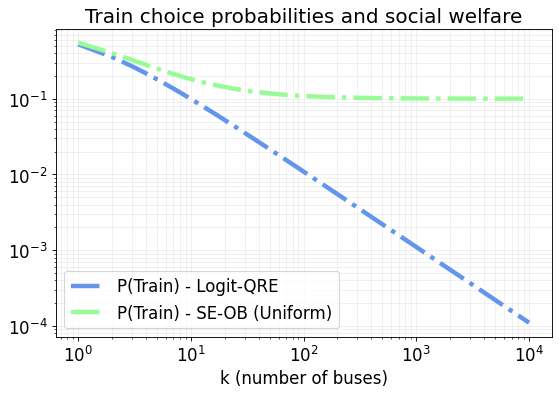

In [ ]:
# Plot probability of Train
plt.figure(figsize=(8, 5), dpi=80)
params = {'text.usetex' : True,
          'font.size' : 25,
          'font.family' : 'Sharif',
          'text.latex.unicode': True,
          }

plt.plot(ks, soft_p, color='cornflowerblue' ,   label='P(Train) - Logit-QRE',  linewidth=4, linestyle='-.')
plt.plot(ks, sparse_p,  color='palegreen', label='P(Train) - SE-OB (Uniform)',linewidth=4, linestyle='-.')
# plt.plot(ks, tsallis_p,  color='coral', label='P(Train) - SE-OB (Pareto)',linewidth=4, ':')

plt.xscale("log")
plt.yscale("log")
plt.xlabel('k (number of buses)')
# plt.ylabel('P(Train)')
plt.title('Train choice probabilities and social welfare')
plt.grid(True, which="both", alpha=0.2)

# # Plot expected welfare
# plt.plot(ks, soft_w,   color='mediumslateblue' ,   label='Welfare - Logit-QRE',  linewidth=4, linestyle='-')
# plt.plot(ks, sparse_w,  color='forestgreen',  label='Welfare - SE-OB (Uniform)',linewidth=4, linestyle='-')
# plt.plot(ks, tsallis_w,  color='indianred',  label='Welfare - SE-OB (Pareto)',linewidth=4, linewidth=':')

plt.legend()

plt.savefig('choice-probs.pdf')
# plt.legend()
# plt.grid(True)

plt.show()
breakpoint()
